In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from forecasting.lib.get_data import getStockPrices

In [14]:
orig_stock_aapl, aapl = getStockPrices('AAPL', history_len = '10y', mov_avg=5, target_col='Close')

c:\Users\shahe\Documents\SuperDataScience\Collaborative Projects\Ongoing\Stock_forecast\forecasting\lib\get_data.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = price_history.fillna(method='ffill')


In [16]:
aapl

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA
2014-07-11,21.087319,21.204519,20.976752,21.056360,136072000,0.0,0.0,21.09
2014-07-14,21.197888,21.425655,21.151450,21.328356,171240000,0.0,0.0,21.12
2014-07-15,21.405757,21.416812,21.014349,21.078478,181911600,0.0,0.0,21.11
2014-07-16,21.443342,21.472089,20.950213,20.959059,213585200,0.0,0.0,21.09
2014-07-17,21.014342,21.069626,20.470354,20.585342,229192000,0.0,0.0,21.00
...,...,...,...,...,...,...,...,...
2024-06-28,215.770004,216.070007,210.300003,210.619995,82542700,0.0,0.0,211.04
2024-07-01,212.089996,217.509995,211.919998,216.750000,60402900,0.0,0.0,212.76
2024-07-02,216.149994,220.380005,215.100006,220.270004,58046200,0.0,0.0,215.00
2024-07-03,220.000000,221.550003,219.029999,221.550003,37369800,0.0,0.0,216.66


<Axes: >

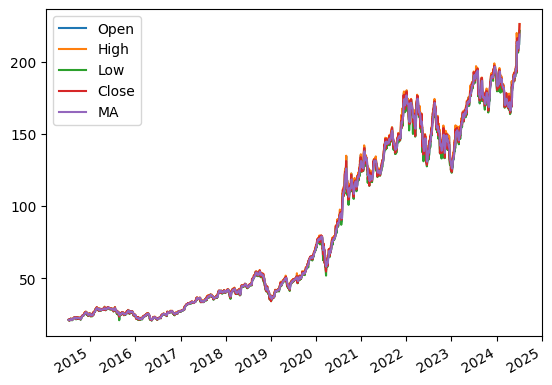

In [47]:
predictors = ['Open','High','Low','Close','MA']
aapl[predictors].plot()

In [52]:
aapl['Tomorrow'] = aapl.Close.shift(-1)
aapl['Target'] = (aapl.Tomorrow > aapl.Close).astype('int')

In [54]:
aapl

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA,Tomorrow,Target
2014-07-11,21.087319,21.204519,20.976752,21.056360,136072000,0.0,0.0,21.09,21.328356,1
2014-07-14,21.197888,21.425655,21.151450,21.328356,171240000,0.0,0.0,21.12,21.078478,0
2014-07-15,21.405757,21.416812,21.014349,21.078478,181911600,0.0,0.0,21.11,20.959059,0
2014-07-16,21.443342,21.472089,20.950213,20.959059,213585200,0.0,0.0,21.09,20.585342,0
2014-07-17,21.014342,21.069626,20.470354,20.585342,229192000,0.0,0.0,21.00,20.881670,1
...,...,...,...,...,...,...,...,...,...,...
2024-06-28,215.770004,216.070007,210.300003,210.619995,82542700,0.0,0.0,211.04,216.750000,1
2024-07-01,212.089996,217.509995,211.919998,216.750000,60402900,0.0,0.0,212.76,220.270004,1
2024-07-02,216.149994,220.380005,215.100006,220.270004,58046200,0.0,0.0,215.00,221.550003,1
2024-07-03,220.000000,221.550003,219.029999,221.550003,37369800,0.0,0.0,216.66,226.339996,1


In [61]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)

train = aapl.iloc[:-100]
test = aapl.iloc[-100:]

predictors = ['Open','High','Low','Close','MA']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(max_depth=100, random_state=0)

In [79]:
from sklearn.metrics import precision_score

preds = pd.Series(model.predict(test[predictors]), index=test.index, name="Predictions")
precision_score(test["Target"], preds)

np.float64(0.38461538461538464)

In [80]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: >

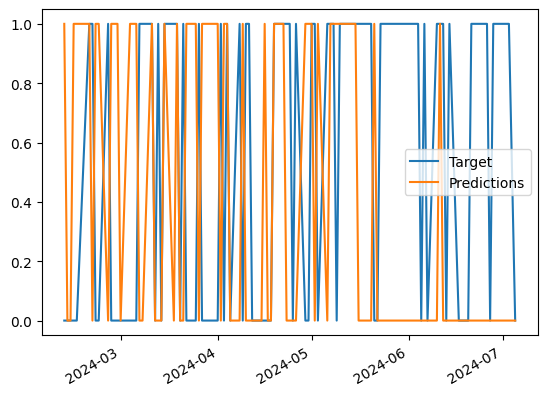

In [81]:
combined.plot()

In [90]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [98]:
def backtest(data, model, predictors, start=250, step=60):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [99]:
predictions = backtest(aapl, model, predictors)

In [100]:
predictions["Predictions"].value_counts()

Predictions
0    1283
1     980
Name: count, dtype: int64

In [101]:
precision_score(predictions['Target'], predictions['Predictions'])

np.float64(0.5387755102040817)

In [ ]:
horizons = [2, 5, 20, 60, 250]

for horizon in horizons:
    rolling_avg = aapl.rolling(horizon).mean()

    ratio_column = f"Close_ratio_{horizon}"
    aapl[ratio_column] = aapl["Close"] / rolling_avg["Close"]

    trend_column = f"Trend_{horizon}"
    aapl[trend_column] = aapl.shift(1).rolling(horizon).sum()["Target"]